## Cell tracking over sessions

* What percentage of cells are present across multiple sessions?
* Are these percentages/patterns affected by the drug treatment?

In [4]:
cd /home/blansdel/projects/schwarz/decoder

/home/blansdel/projects/schwarz/decoder


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from itertools import combinations, product
from collections import Counter
from scipy.stats import chi2_contingency

from src.lib import *

In [13]:
sessions = [2, 6, 7, 9]

fn_in = './data/input/explore.csv'
df = pd.read_csv(fn_in)
conditions = df.treatment.unique()

Number of cells by recording day

In [14]:
counts_by_day = np.zeros((3, 2, 4))
for i, cond in enumerate(conditions):
    cell_sums, cell_stats, cell_sums_list, animals = compute_stats(df, cond)
    for j, animal in enumerate(animals):
        counts_by_day[i,j] = np.sum(np.stack(list(cell_stats[animal].values())), axis = 0)

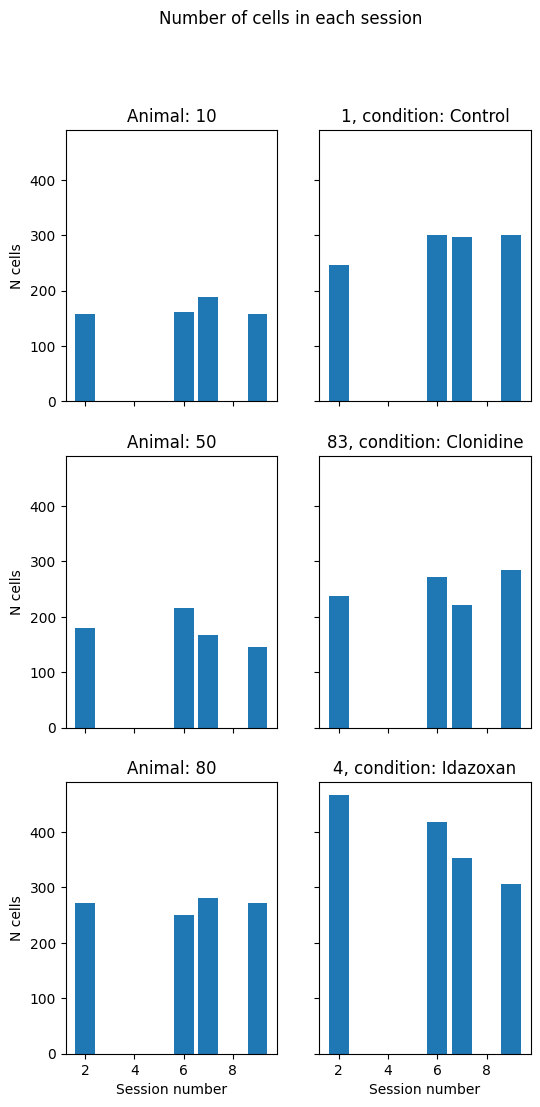

In [15]:
fig, axes = plt.subplots(3,2, figsize = (6,12), sharex = True, sharey = True)
for i,j in product(range(3), range(2)):
    cell_sums, cell_stats, cell_sums_list, animals = compute_stats(df, conditions[i])
    axes[i,j].bar(sessions, counts_by_day[i,j], label = ['2', '6', '7', '9'])
    if j == 0:
        axes[i,j].set_ylabel('N cells')
    title = f'Animal: {animals[j]}'
    if j == 1:
        title += f', condition: {conditions[i]}'
        title = title.replace('Animal: ', '')
    axes[i,j].set_title(title)
    if i == 2:
        axes[i,j].set_xlabel('Session number')
fig.suptitle("Number of cells in each session");

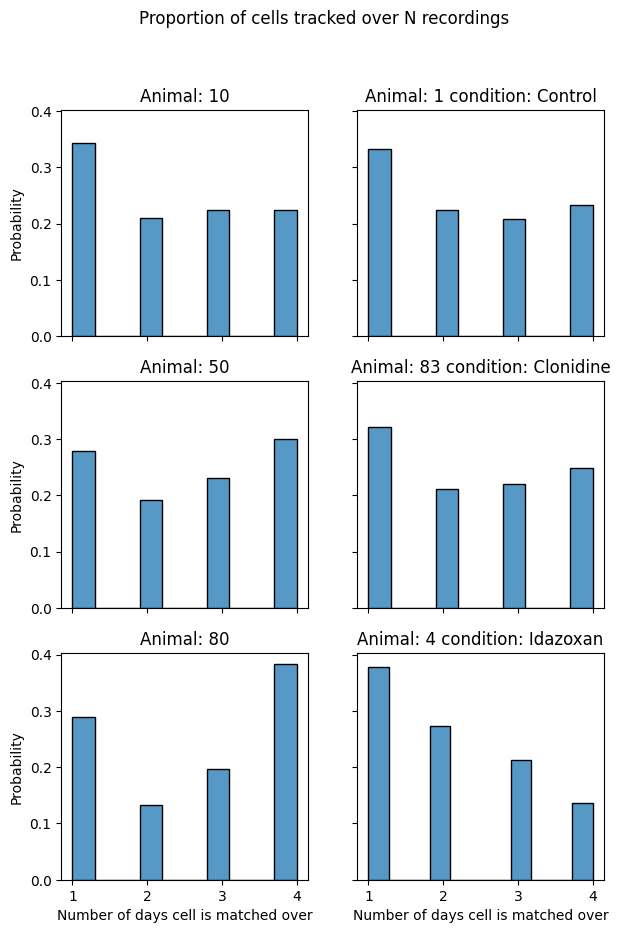

In [16]:
fig, axes = plt.subplots(3, 2, figsize = (7, 10), sharex = True, sharey = True)
cell_sums, cell_stats, cell_sums_list, animals = compute_stats(df, conditions[0])
sns.histplot(cell_sums_list[animals[0]], ax = axes[0,0], stat = 'probability')
axes[0,0].set_title(f'Animal: {animals[0]}')
sns.histplot(cell_sums_list[animals[1]], ax = axes[0,1], stat = 'probability')
axes[0,1].set_title(f'Animal: {animals[1]} condition: {conditions[0]}')
cell_sums, cell_stats, cell_sums_list, animals = compute_stats(df, conditions[1])
sns.histplot(cell_sums_list[animals[0]], ax = axes[1,0], stat = 'probability')
axes[1,0].set_title(f'Animal: {animals[0]}')
sns.histplot(cell_sums_list[animals[1]], ax = axes[1,1], stat = 'probability')
axes[1,1].set_title(f'Animal: {animals[1]} condition: {conditions[1]}')
cell_sums, cell_stats, cell_sums_list, animals = compute_stats(df, conditions[2])
sns.histplot(cell_sums_list[animals[0]], ax = axes[2,0], stat = 'probability')
axes[2,0].set_title(f'Animal: {animals[0]}')
sns.histplot(cell_sums_list[animals[1]], ax = axes[2,1], stat = 'probability')
axes[2,1].set_title(f'Animal: {animals[1]} condition: {conditions[2]}')
axes[2,1].set_xlabel("Number of days cell is matched over")
axes[2,0].set_xlabel("Number of days cell is matched over")
fig.suptitle("Proportion of cells tracked over N recordings");

Pooling animals together:

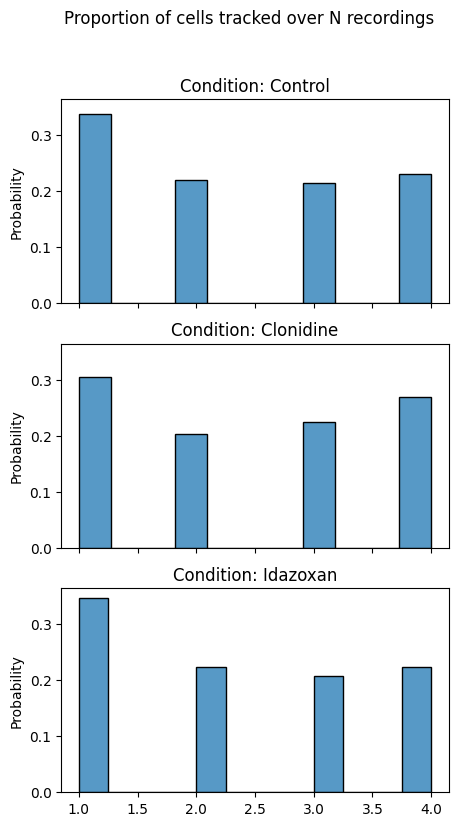

In [17]:
fig, axes = plt.subplots(3, 1, figsize = (5, 9), sharex = True, sharey = True)
cell_sums, cell_stats, cell_sums_list, animals = compute_stats(df, conditions[0])
csl = cell_sums_list[animals[0]] + cell_sums_list[animals[1]]
sns.histplot(csl, ax = axes[0], stat = 'probability')
axes[0].set_title(f'Condition: {conditions[0]}')
cell_sums, cell_stats, cell_sums_list, animals = compute_stats(df, conditions[1])
csl = cell_sums_list[animals[0]] + cell_sums_list[animals[1]]
sns.histplot(csl, ax = axes[1], stat = 'probability')
axes[1].set_title(f'Condition: {conditions[1]}')
cell_sums, cell_stats, cell_sums_list, animals = compute_stats(df, conditions[2])
csl = cell_sums_list[animals[0]] + cell_sums_list[animals[1]]
sns.histplot(csl, ax = axes[2], stat = 'probability')
axes[2].set_title(f'Condition: {conditions[2]}')
fig.suptitle("Proportion of cells tracked over N recordings");

Are these counts significantly different?

In [18]:
#Form contingency tables
contingencies = np.zeros((3,4))
for idx in range(3):
    cell_sums, cell_stats, cell_sums_list, animals = compute_stats(df, conditions[idx])
    csl = cell_sums_list[animals[0]] + cell_sums_list[animals[1]]
    csl_counts = Counter(csl)
    csl_counts_ = [csl_counts[k] for k in range(1,5)]
    contingencies[idx,:] = csl_counts_
    
# Two-sample chi-square test
for i,j in combinations(range(3), 2):
    result = chi2_contingency(contingencies[[i,j],:])
    print(f'Chi2 test {conditions[i]} vs {conditions[j]}: {result[1]}')

Chi2 test Control vs Clonidine: 0.251428024411256
Chi2 test Control vs Idazoxan: 0.9543388503945165
Chi2 test Clonidine vs Idazoxan: 0.06222641610595609


*Not* significantly different.

## How many cells are matched, at all, per session?

Now, for each pair or recordings, what proportion of cells are matched between the recs?

In [23]:
matching_matrix = np.zeros((3, 2, 4, 4))

for c_i, cond in enumerate(conditions):
    cell_sums, cell_stats, cell_sums_list, animals = compute_stats(df, cond)
    for a_j, animal in enumerate(animals):
        animal_stats = np.stack(cell_stats[animal].values())

        #Of all cells present in s1, how many are present in s2?
        for s1, s2 in product(range(4), range(4)):
            if s1 == s2:
                matching_matrix[c_i, a_j, s1, s2] = 0
                continue
            a_stats = animal_stats[animal_stats[:,s1] == 1, s2]
            matching_matrix[c_i, a_j, s1, s2] = a_stats.sum()/a_stats.shape[0]
            
# find minimum of minima & maximum of maxima
minmin = np.min(matching_matrix)
maxmax = np.max(matching_matrix)

#Plot mean proportion as a function of days from the recording
#Take mean over animals
mean_matching_matrix = np.mean(matching_matrix, axis = 1)

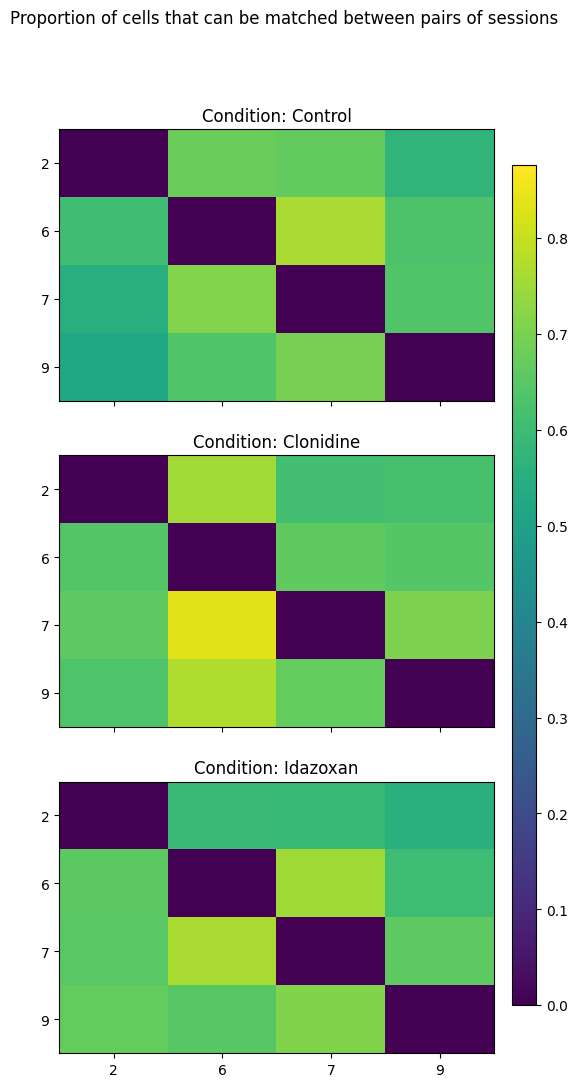

In [24]:
fig, axes = plt.subplots(3,1, figsize = (6,12), sharex = True, sharey = True)
for i in product(range(3)):
    cell_sums, cell_stats, cell_sums_list, animals = compute_stats(df, conditions[i])
    ims = axes[i].imshow(mean_matching_matrix[i,:,:].squeeze(), vmin = minmin, vmax = maxmax, aspect = 'auto')
    axes[i].set_xticks(range(4))
    axes[i].set_xticklabels(sessions)
    axes[i].set_yticks(range(4))
    axes[i].set_yticklabels(sessions)
    title = f'Condition: {conditions[i]}'
    axes[i].set_title(title)
fig.suptitle("Proportion of cells that can be matched between pairs of sessions");
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(ims, cax=cbar_ax);